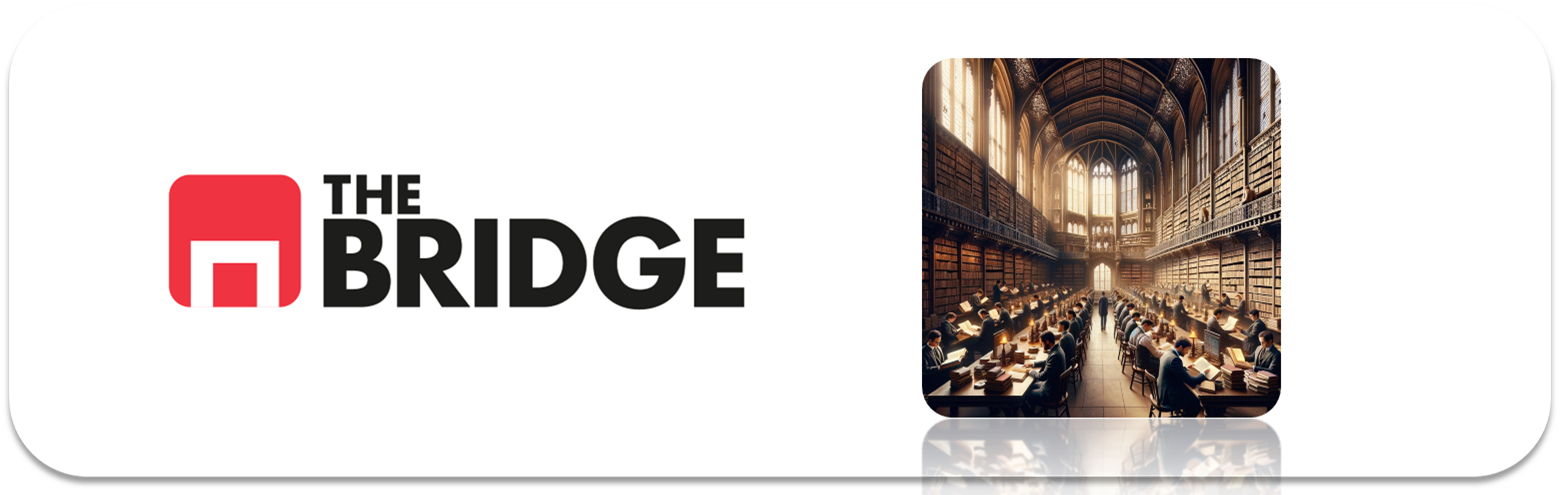

## APLICACIONES ML (II): Procesamiento de Lenguaje Natural (NLP)

El departamento de marketing de un sistema de streaming (Showtimes) quiere clasificar automáticamente las reviews de los usuarios de su servicio fremium en el que dejan que estos puedan ver parte de su catálogo a cambio de que hagan valoraciones de las películas y series que ven. En concreto están interesados en saber hasta que punto una review es positiva o negativa a partir de un dataset etiquetado por expertos que han revisado miles de reviews (25K) y las han etiquetado como positivas o negativas. Ahora quieren tener un sistema de ayuda al etiquetado y de preclasificación.  

En definitiva, sobre un dataset que ya tienen trabajado quieren que les creemos un modelo que dada una review la clasifique en positiva o negativa. Pero sobre todo están interesados en que su sistema detecte las reviews negativas al mayor porcentaje posible para estar a tiempo de reaccionar con el contenido. Una vez clasificadas como negativas pasarían a un segundo nivel de revisión pero no quieren dejar pasarlas y tampoco sobrecargar este sistema por lo que a pesar de querer una detección alta, necesitan que el sistema no se equivoque más de un 30% cuando diga que una review es negativa.

### Paso I: Entendiendo el problema

En este caso, entender el problema es:
1. Saber que se trataría de un aprendizaje supervisado (datos etiquetados en positivas y negativas)
2. Saber que es un clasficador binario.
3. Saber que tendremos que tratar texto en lenguaje natural (las reviews) y no formal, ni escrito literariamente.
4. Entender que la métrica que se pide es el recall de las reviews negativa con una precision de más de un 70% de dicha clase.

### Paso II: Obtención de los datos y primer vistazo (y split train y test)

Antes de obtener los datos, vamos a hacer nuestra carga de librerías y modulos necesarios:

In [ ]:
import bootcampviztools as bt
import numpy as np
import pandas as pd
import re
#import osm
#import reb
import warnings
warnings.filterwarnings("ignore")


from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV



Vamos a cargar el dataset del modulo de datasets que tiene Python, simulando que es Showtimes la que nos envía la info:

In [ ]:
from datasets import load_dataset

reviews_ds = load_dataset("imdb", split="train")

In [ ]:
reviews_ds["text"][0:2]

In [ ]:
reviews_ds["label"][0:2]

Vamos a transformarlo en un dataframe:

In [ ]:
df = pd.DataFrame( {"reseña":reviews_ds["text"], "valoración": reviews_ds["label"]})

Vamos con el vistazo:

In [ ]:
df.head()

In [ ]:
df.info()

Bueno, pues este es uno de los "problemas" o trabajos en los que sólo tenemos texto en lenguaje natural como fuente de información (salvo CatBoost, en el momento de escribir esto), no hay modelo (no Deep) que lo soporte tal cual. Esto es nuestra actual feature:

In [ ]:
print(df.head(1)["reseña"].values)

### Parte III: Train Test split

In [ ]:
train_set, test_set = train_test_split(df, test_size = 5000, stratify = df["valoración"], random_state = 42)
train_set.reset_index(inplace = True)
test_set.reset_index(inplace = True)

In [ ]:
train_set["valoración"].value_counts(True)

In [ ]:
test_set["valoración"].value_counts(True)

In [ ]:
target = "valoración"

### Parte IV: MiniEDA específico:

Primero veamos el target y luego iremos a la parte "específica" de preparación de features de un ML sobre NLP.

In [ ]:
bt.pinta_distribucion_categoricas(train_set, [target], mostrar_valores= True, relativa= True)

Ya lo sabíamos del value_counts, y hazle una foto porque como este no vamos a ver un dataset muchas veces más. Completamente equilibrado, "accuracy" nos vale como métrica.

***

### Parte IV.1: Extracción de Features: Vectorización de Textos

Siempre que tengamos un tipo de dato no estructurado (no tabular en general, como imágenes o textos) tendremos que entrar en esta parte, cómo obtener sus features como traducirlo en algún tipo de vector que los modelos puedan manejar (en las imágenes ya hemos hecho una vectorización, convertir cada imagen en una instancia cuyas features son el valor de color o gris de cada uno de sus píxeles puestos uno detrás de otro).  

Ahora vamos a aprender un par de formas de vectorizar un texto es decir convertirlo en un vector de features que ya si podremos dar de "comer" a un modelo y tratarlas como hemos tratado cualquier feature hasta ahora.

Vamos a seguir los siguientes pasos:
1. Limpieza y tokenizacion
2. Vectorización texto (I): Bag of Words (BOW) binario y no binario
3. Vectorización texto (II): Tf-idf (term frequency inverse document frequency)
4. Vectorización texto (IV): Usando n-gramas


#### Limpiamos (y tokenizamos)

OBJETIVO: Dejar las palabras/tokens y quitar todo lo que no sea eso
Limpiar en procesamiento de texto básicamente consiste en quitar del texto todos los elementos que no aportan (signos de puntuación) para reducir el texto al conjunto de palabras/tokens que sí consideramos interesantes.  
A) En general vamos a quitar dos cosas:
1. Signos de puntuación y caracteres que no son texto _[Ojo: Tener en cuenta las dependencias con el idioma]_
2. URLs, hashtags, emojis, etc
3. Stopwords (palabras que en un idioma se repiten mucho, o tienen un significado gramatical y no léxico)

Puede haber situaciones especiales en las que quiera conservar algunos de los elementos anteriores (por ejemplo los hashtags o los emojis si estoy procesando mensajes de redes sociales)

B) Pasaremos todo a minúsculas (también depende de si quiero extraer Nombres Propios, entonces este sería mi último paso antes de generar el dataset final)

**Limpieza básica**

In [ ]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)") # Si volvemos a las expresiones regulares, :-), en texto no queda otra si no eres un LLM
REPLACE_WITH_SPACE = re.compile("(<br \s*/><br\s*/>)|(\-)|(\/)|(_)")
NO_SPACE = ""
SPACE = " "


def clean(row):
    # Limpio signos y convierto a minúsculas
    dato = REPLACE_NO_SPACE.sub(NO_SPACE, row.lower()) # Equivale a re.sub("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)", NO_SPACE, row.lower())
    # Convierto los retornos de carro <br /><br /> en espacios y los guiones ("-")
    dato = REPLACE_WITH_SPACE.sub(SPACE, dato) # Equivale a re.sub("(<br \s*/><br\s*/>)|(\-)|(\/)|(_)", SPACE, dato)
    # Quito cualquier link
    dato = " ".join([word for word in dato.split() if "http" not in word])
    # Quito los stopwords
    return dato

$$*$$

In [ ]:
train_set["reseña_limpia"] = train_set["reseña"].apply(clean)
test_set["reseña_limpia"] = test_set["reseña"].apply(clean)

In [ ]:
print(train_set.loc[0,"reseña"])

In [ ]:
print(train_set.loc[0,"reseña_limpia"])

**Stopwords**

Stop words are the very common words like ‘if’, ‘but’, ‘we’, ‘he’, ‘she’, and ‘they’. We can usually remove these words without changing the semantics of a text and doing so often (but not always) improves the performance of a model.

Las palabras "vacías" o `stopwords` (en terminología NLP) son palabras muy comunes como 'si', 'pero', 'porque', 'y' (en inglés, otras como  ‘if’, ‘but’, ‘we’, ‘he’, ‘she’, y ‘they’), que no aportan significado léxico o semántico y que, generalmente podemos eliminar estas palabras sin cambiar la semántica de un texto y hacerlo a menudo (pero no siempre) mejora el rendimiento de un modelo.

In [ ]:
from nltk.corpus import stopwords
stopwords.words('english')[:10]

Sí, para cada idioma necesito unas stopwords, un diccionario particularizado

In [ ]:
stopwords.words("spanish")[:10]

In [ ]:
dictionary = stopwords.words("english")
def remove_stopwords(row):
    dato = " ".join([word for word in row.split(" ") if word not in dictionary])
    return dato

In [ ]:
train_set["reseña_limpia_sin_stopwords"] = train_set["reseña_limpia"].apply(remove_stopwords)
test_set["reseña_limpia_sin_stopwords"] = test_set["reseña_limpia"].apply(remove_stopwords)

In [ ]:
print(train_set.loc[0,"reseña_limpia"])

In [ ]:
print(train_set.loc[0,"reseña_limpia_sin_stopwords"])

**Sobre tokens y tokenizacion**

Fíjate en como ha quedado convertido el texto original de cada reseña. Lo hemos reducido a **palabras significativas o "tokens"**. En el contexto de NLP, un token es la unidad básica de procesamiento de textos, y, normalmente, se refiere a palabras con significado. Pero con la evolución de la IA y del NLP, el token ha pasado de tener la obligación de ese significado semántico, ahora hay subtokens (como las terminaciones o los prefijos) y una definición más adecuada de token sería: 

**Token** = Unidad básica de texto procesada. Puede ser una palabra, un carácter, o incluso un subconjunto de una palabra. Los tokens son los componentes individuales en los que se divide el texto para su análisis o para entrenar modelos. 

En general, vamos a seguir considerando tokens a las palabras, pero es iportante que tengas en cuenta que ya no siemprbe coinciden con palabras enteras.

La **tokenizacion** es el proceso por el cual un texto se convierte en tokens. Lo hemos hecho a mano, para que veas el proceso, pero existen tokenizadores ya especializados (por ejemplo nltk tiene sus tokenizer, prueba a jugar con ellos).

Una vez tokenizados, convertidos a tokens, la vectorización es la que nos permite ahora convertir esos tokens en números y con ello en features asignables a cada instancia. Vamos a ello.

In [ ]:
train_set.rename(columns = {"reseña_limpia_sin_stopwords": "tokenizada"}, inplace = True)
test_set.rename(columns = {"reseña_limpia_sin_stopwords": "tokenizada"}, inplace = True)

***

#### Vectorización de Texto (I): Bag_of_words (BoW)


Vamos a contruir un vector con tantas dimensiones como palabras/tokens haya (en todo el dataset) y para cada texto y cada dimensión vamos a rellenar con el número de veces que aparece el token en cada texto o bien binariamente (1 si aparece 1 o más veces, 0 si no aparece) o bien frecuencialmente (pondremos el número de veces que aparece el token en el texto).
* Al conjunto de tokens de todo un dataset se le llama vocabulary
* Al conjunto de todos los textos también se le llama corpus



#### Vectorizacion binaria

Vamos a apoyarnos en sklearn y en concreto en `CountVectorizer`. Esta clase, al hacer un `fit` construye un diccionario de tokens con todos los tokens diferentes que encuentra en el dataset que se le pasa como parámetro al método `fit`. Se puede limitar dicho diccionario de diversas formas (eliminando palabras muy frecuentes y poco frecuentes, quedándote sólo con las que superan una frecuencia de aparición considerando todas las instancias, etc) y además se puede pasar un diccionario como argumento. Te invito a que investigues todas sus posibilidades, y no sólo las que tienen que ver con el diccionario, [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Si aparece una palabra en una review, le pone un 1. Da igual que aparezca 100 veces, no cuenta. Xq binary=True
# Solo pone 1s cuando detecta una palabra en una review
prepro_vectorizer = CountVectorizer(binary=True, max_features = 32000) # Vamos a considerar un diccionario con los 32k tokens más usados
prepro_vectorizer.fit(train_set["tokenizada"]) # Al hacer el fit, se construye un diccionario de tokens

In [ ]:
prepro_vectorizer.vocabulary_

In [ ]:
vectors_preprocesed_train = prepro_vectorizer.transform(train_set["tokenizada"])
vectors_preprocesed_test = prepro_vectorizer.transform(test_set["tokenizada"]) # Se usa el diccionario de train, si algun token de test no aparece en train no se contará

Las transformaciones de sklearn son como su one-hot encoder (sí de hecho es lo que hacemos con una vectorización binaria), es decir devuelven una matriz sparse (no todos los datos)

In [ ]:
type(vectors_preprocesed_train)

In [ ]:
len(prepro_vectorizer.get_feature_names_out()) # Aquí es donde están ordenadas las apariciones, para poder construir un dataframe a partir de la matriz sparse

In [ ]:
X_train_binary_vectorized = pd.DataFrame(vectors_preprocesed_train.toarray(), columns = prepro_vectorizer.get_feature_names_out())
X_test_binary_vectorized = pd.DataFrame(vectors_preprocesed_test.toarray(), columns = prepro_vectorizer.get_feature_names_out())

In [ ]:
X_train_binary_vectorized

In [ ]:
X_train_binary_vectorized["brosnan"].value_counts()

Si te parecían poco los 32K tokens puedes ver que hemos considerado alguno "discutible" ("\_is\_","\_the","ème") que también pueden hacer replantearte una limpieza mayor (quitar esos "\_"). De hecho eso haríamos, ahora volver al principio y relimpiar, pero por temas de tiempo seguimos adelante.

#### Vectorizacion no-binaria

Ahora se tiene en cuenta el número de veces que aparece cada token en el texto correspondiente.

In [ ]:
prepro_vectorizer = CountVectorizer(binary = False, max_features = 32000) # tengo en cuenta todas las apariciones
X_vectors_train_freq = prepro_vectorizer.fit_transform(train_set["tokenizada"]) # Los vamos a manetener como sparse matrix para acelerar los entrenamientos
X_vectors_test_freq = prepro_vectorizer.transform(test_set["tokenizada"])

In [ ]:
df_train_vectorized_bow_freq = pd.DataFrame(X_vectors_train_freq.toarray(), columns = prepro_vectorizer.get_feature_names_out())
#df_test_vectorized_bow_freq = pd.DataFrame(vectors_preprocesed_test.toarray(), columns = prepro_vectorizer.get_feature_names_out())

Para ver las diferencias busquemos algún token que pueda aparecer más de una vez, como por ejemplo (si acertaste lo tenía preparado), "yellow":

In [ ]:
df_train_vectorized_bow_freq["yellow"].value_counts()

Y si lo vemos en el vectorizado binario:

In [ ]:
X_train_binary_vectorized["yellow"].value_counts()

Por curiosidad, quien repite "yellow", 7 veces

In [ ]:
print(train_set.loc[df_train_vectorized_bow_freq.yellow == 7, "reseña"].values)

Es una pena no tener el título porque verías que la película a la que hace referencia es la primera del dataset "I am a curious yellow" (no preguntes más, la conozco tanto como tú)

***

#### Vectorizacion de texto (II): con tf-idf

Otra forma común de representar las "features" de texto en lenguaje natural en un dataframe es utilizar la estadística tf-idf (frecuencia de término-frecuencia inversa de documento) para cada palabra/token, que es un factor de ponderación que podemos usar en lugar de representaciones binarias o de conteo de palabras.

*NOTA*: Antes de continuar, un poco de terminología NLP. En NLP se designa como **documento** a cada fragmento de texto a vectorizar o analizar por individual, en nuestro caso cada reseña sería un documento. Y se desgina como **corpus** al conjunto completo de documentos que se tratan de forma agrupada, en nuestro caso el corpus del train es el conjunto total de reseñas del train y el corpus del test sería el conjunto total de reseñas del test. Sigamos.

Existen varias formas de realizar la transformación tf-idf, pero en esencia, tf-idf pretende representar el número de veces que una palabra dada aparece en un documento (una reseña de película en nuestro caso) en relación con el número de documentos (reseñas) en el corpus (todas las reseñas de train o de test) en los que aparece la palabra.

Por cada token en un texto se hace el cáculo de su tf-idf y eso es lo que se almacena.
Para cada texto, pasa por cada token del texo:  
    * Calculamos tf -> El número de veces que aparece ese token/El número de tokens que hay en el documento/instancia (en nuestro caso el número de veces que un token aparece en la review que estamos vectorizando)  
    $$tf(token_x) = num\_apariciones\_token_x$$
    * Calculamos la idf -> la inversa de una medida de la frecuencia de aparición del token en todos los textos del dataset/corpus:
    $$idf(token_x) = \log({\frac{len(dataset)}{df(token_x)}}) + 1,\text{donde }df(token_x)\ \text{es el número de reseñas en las que aparece el token x}$$ 
    * Y el valor que almacenaríamos en la feature del texto para el token es el producto de los dos valores anteriores. Y digo almacenaríamos porque sklearn aplica dos modificaciones por defecto, una fórmula suavizada y una normalización (una divisón del valor total por la norma del vector resultante (pero a efectos teóricos lo que se está haciendo es una ponderación de los valores en función de las frecuencias de aparición).


Veamos un ejemplo sencillo y luego lo aplicaremos a nuestro train y nuestro test... por supuesto, tiramos de scikit-learn:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfTransformer
'''
Cuanto mas comun, mas bajo es el TfidfVectorizer
'''
sent1 = 'My name is Ralph'
sent2 = 'Ralph is fat'
sent3 = 'Ralph'

test = TfidfVectorizer(smooth_idf= False, norm = None) # Para que sea la fórmula anterior, sino usa una para suavizar
valores = test.fit_transform([sent1, sent2, sent3])
df_test_tfidf = pd.DataFrame(valores.toarray(), columns = test.get_feature_names_out())
df_test_tfidf["Sent"] = [sent1,sent2,sent3]
df_test_tfidf

In [ ]:
1*(np.log(3/2)+1)

Apliquémoslo a nuestro train y test:

In [ ]:
vectorizador_tfidf = TfidfVectorizer(max_features = 32000)
vec_train_tfidf = prepro_vectorizer.fit_transform(train_set["tokenizada"])
vec_test_tfidf = prepro_vectorizer.transform(test_set["tokenizada"])
features_tfidf = prepro_vectorizer.get_feature_names_out()

Por ahora y para ahorrar memoria no lo vamos a expandir a un dataset, de hecho te mostraré que puedes usar las sparse matrix en sklearn directamente. 

Desde un punto de vista un poco "grosero" el tf-idf se podría considerar como una normalización o escalado particular bastante interantes (porque se adapta a las propiedades genéricas del corpus) para un BoW normal.

#### Vectorización de texto (III): Con n-gramas

Finalmente, vamos a cambiar la unidad de referencia, en vez de ser el token vamos a utilizar lo n-gramms (n-gramas).  
Un **n-gramma** es una combinación de n palabras/tokens que van seguidas. n = 1 -> token.  
Podemos hacer que en vez de contar tokens se cuenten n-grams, y además no sólo un tipo de n-gram, puedo incluir tokens (1-grams), bi-grams (2-grams), tri-gramas (3-grams)... etc y lo que haremos será vectorizar como hemos hecho antes pero sobre los n-gramas.

Para que veas el concepto:

In [ ]:
from nltk import ngrams

sentence = 'this is foo bar'

two = ngrams(sentence.split(), 2)
three = ngrams(sentence.split(), 3)

print(sentence)
print("2-grams")
for grams in two:
    print(grams)
print('###############')
print("3-grams")
for grams in three:
    print(grams)




Entonces ahora en vez de considerar los tokens sueltos iremos considerando agrupaciones de 2,3,.., n tokens que aparezcan seguidos (es decir para el ejemplo anterior en el caso de bigramas, 2-gram, n= 2, no  buscaríamos cuánto aparecen "this", "is","foo" o "bar", buscaríamos cuánto aparecen "this is", "is foo", etc, etc). Te puedes imaginar que esto dispara aún más nuestro número de features en la vectorización y  más si además no sólo me centro en bigramas sino en tokens y bigramas juntos, etc, etc. Como la explosión combinatoria de la regresión polinómica.

In [ ]:
ngram_vectorizer = CountVectorizer(binary=True,
                                   ngram_range=(1, 3)) # Va contar para los tokens originales, para 2-gramms y para 3-gramms

vector = ngram_vectorizer.fit_transform([sentence]).toarray()
print(vector)
print(len(vector[0]))
print(ngram_vectorizer.vocabulary_.keys())
pd.DataFrame(vector, columns= ngram_vectorizer.get_feature_names_out())

Debido al uso de memoria, no vamos a aplicarlo a nuestro dataset inicial y no entrenaremos con ello, solo vamos a ver como sería el diccionario o vocabulario que se obtendría:

In [ ]:
import random as rm
ngram_vectorizer.fit(train_set["tokenizada"])
print(rm.sample([(ngrama,feature_num) for ngrama,feature_num in ngram_vectorizer.vocabulary_.items()],10))

In [ ]:
print(len(ngram_vectorizer.get_feature_names_out()))

Ufffff!!! Ese el número de features que obtendríamos de hacer la vectorización aunando tokens, bigramas y trigramas. No lo vamos a hacer, pero con tiempo y recursos podrías planteartelo.

***

### Parte IV.2: Selección/Reducción de Features

Ya tenemos las features:

In [ ]:
print("Features para vectorización binaria:", X_train_binary_vectorized.shape[1])
print("Features para vectorización no binaria:", X_vectors_train_freq.shape[1])
print("Features para vectorización tf-idf:", len(prepro_vectorizer.get_feature_names_out()))

Todas as 32K porque es el número de entradas en el vocabulario/diccionario que permitimos. Ahora podríamos hacer una reducción de features con los mecanismos que vimos en el sprint anterior (menos el visual, claro), incluyendo la PCA. No lo vamos a hacer, por limitaciones de tiempo, pero puedes ver como aquí sí que aplica una buena reducción de la dimensionalidad (32K features > 20K instancias)

Lo que si vamos a hacer es **<u>comentar** (no da para más esta parte introductoria) dos formas específicas de NLP para reducir features que se aplican OJO antes de la vectorización

#### INCISO: REDUCCION FEATURES EN NLP

Hasta ahora hemos usado cada "palabra" como un token. Pero hay muchas palabras que en realidad están muy relacionadas y puede ser interesante considerarlas como la misma. Por ejemplo: 
- las formas verbales de un mismo verbo: pienso, pensé, pensasteís (ahora las consideramos como tokens distintos, pero puede que nos interese sólo considerarlo como <pensar>)
- Los plurales: casas, casa -> ahora son dos tokens, pero igual quiero considerarlo sólo como una feature (casa)
- Los adjetivos: simpático, simpática, simpáticos, simpáticas -> dejarlo en simpatica

Tenemos dos formas de hacerlo: stemming y lemmatization
- stemming: buscamos la "raiz" de la palabra quitando prefijos y sufijos -> prefabricado, fabrica se convierten en fabric
- lemmatization: buscamos el "lemma", raiz léxica, de la palabra (la palabra original de la que viene, en los verbos por ejemplo su infinitivo) -> corriendo, corrí se convierten en correr

Pasaremos el Stemming y la Lemmatization (UNO U OTRO) y después haremos la vectorización, 

Aquí te dejo el código para que puedas aplicarlo a los datasets (pero en local, es decir en tu ordenador), pero nosotros no vamos a ejecutarlo, recuerda que es antes de la vectorización que quieras aplicar.

**Stemming [NO EJECUTAR EN LA PLATAFORMA]**

NLTK has several stemming algorithm implementations. We’ll use the Porter stemmer. Most used:

    PorterStemmer
    SnowballStemmer

Apply a PoterStemmer, vectorize, and train the model again

In [ ]:
from nltk.stem.porter import PorterStemmer
stemmer_eng = PorterStemmer()

plurals = ['caresses', 'flies', 'dies', 'mules', 'denied',
            'died', 'agreed', 'owned', 'humbled', 'sized',
            'meeting', 'stating', 'siezing', 'itemization',
            'sensational', 'traditional', 'reference', 'colonizer',
            'plotted']
singles = [stemmer_eng.stem(plural) for plural in plurals]

print(' '.join(singles))

Para español SnowballStemmer

In [ ]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('spanish')

plurals = ['corriendo', 'casas', 'playa', 'volando', 'volar', 'volveré']
singles = [stemmer.stem(plural) for plural in plurals]

print(' '.join(singles))

In [ ]:
def stemming_eng(row):
    return stemmer_eng.stem(row)

```python
train_set["tokenizada_stemmed"] = train_set["tokenizada"].apply(stemming_eng)
test_set["tokenizada_stemmed"] = test_set["tokenizada"].apply(stemming_eng)
prepro_vectorizer = CountVectorizer(binary=True)
prepro_vectorizer.fit(train_set["tokenizada_stemmed"])
vectors_preprocesed = prepro_vectorizer.transform(train_set["tokenizda_stmmed")
# Y aquí vendría la parte del test y la conversión a dataframe, si la necesitas y que sólo tienes que adaptar de las secciones anteriores*
```

**Lemmatization [NO EJECUTAR EN LA PLATAFORMA]**

In [ ]:
'''
La diferencia con el stemming es que la lematización tiene en cuenta la morfología
de la palabra, sustituyendola por la raiz, no recortándola. Y no es tan restrictivo como el stemming.
Necesita un buen diccionario con mapeos, como wordnet

En nltk no hay lematizadores en español. Habria que bajarse algun paquete como pip install es-lemmatizer
'''

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

plurals = ['caresses', 'flies', 'dies', 'mules', 'studies',
            'died', 'agreed', 'owned', 'humbled', 'sized',
            'meeting', 'stating', 'siezing', 'itemization',
            'sensational', 'traditional', 'reference', 'colonizer',
            'plotted']
singles = [lemmatizer.lemmatize(plural) for plural in plurals]

print(' '.join(singles))

```python
def lemmatized_text(word):
    return lemmatizer.lemmatize(word)

train_set["tokenizada_lemmatized"] = train_set["tokenizada"].apply(lemmatized_text)
test_set["tokenizada_lemmatized"] = test_set["tokenizada"].apply(lemmatized_text)
prepro_vectorizer = CountVectorizer(binary=True)
prepro_vectorizer.fit(train_set["tokenizada_lemmatized")

vectors_preprocesed = prepro_vectorizer.transform(train_set["tokenizada_lemmatized)
# Y aquí vendría la parte del test y la conversión a dataframe, si la necesitas y que sólo tienes que adaptar de las secciones anteriores*
```
                                                  

***

### Parte V: Escoger modelos con Cross_Validation

En este tipo de tarea nos vale muy bien una Regresión Logística o un SVM (sí, lo sé) con kernel lineal y debido al número de features los árboles sufren si no controlamos el número de features a considerar.

In [ ]:
y_train = train_set[target]
y_test = test_set[target]

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from time import time

feature_sets = {
    "BoW Binaria": X_train_binary_vectorized,
    "BoW No-Binaria": X_vectors_train_freq,
    "BoW Tf-idf": vec_train_tfidf
}

lr_clf = LogisticRegression(max_iter = 10000)
rf_clf = RandomForestClassifier(max_features = 60, random_state= 42)
svm_clf =LinearSVC(random_state = 42)


modelos = {
    "Regresion Logistica": lr_clf,
    "SVM": svm_clf,
    "Random Forest": rf_clf
}



In [ ]:
¡¡¡¡NO EJECUTAR EN LA PLATAFORMA!!!! Consume muchos recursos

for nombre,set in feature_sets.items():
    t_zero = time()
    print(f"Para <{nombre}>:")
    for name, model in modelos.items():
        #metrica = 1
        metrica = np.mean(cross_val_score(model, set, y_train, cv = 5 if "Random" not in name else 3, scoring = "accuracy"))
        print(f"\t{name}, score: {metrica}, elapsed: {time() - t_zero}")

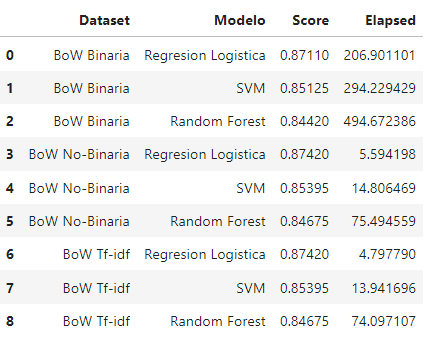

Nos quedamos con la regresión logística y con la vectorización por tf-idf, además es interesante que te fijes en los tiempos para que cuando tengas que trabajar con matrices muy dispersas y ya la tengas con ese tipo en numpy lo hagas directamente y no las transformes.

### Parte VI: Ajuste de hiperparámetros

Solo vamos a ajustar el factor de penalización, recuerda que es el inverso del alfa de regularización l1 o l2 o elastic net, es decir a menos más regularización.

In [ ]:
param_grid = {
    "C": [0.1,0.2,0.6,1,10]
}

lr_grid = GridSearchCV(lr_clf,
                       param_grid = param_grid,
                       cv = 5,
                       scoring = "accuracy"
                      )

lr_grid.fit(vec_train_tfidf, y_train)

In [ ]:
lr_grid.best_params_

In [ ]:
lr_grid.best_score_

In [ ]:
y_pred = lr_grid.best_estimator_.predict(vec_test_tfidf)
print(classification_report(y_test, y_pred))

No está nada mal, ya tenemos el modelo que Showtimes quería, un recall estupendo y una precisión por encima del 70%.

### Parte VII: Analisis de errores/coeficientes

Ahora tocaría el momento de analizar probabilidades (ya que al ser un clasificador binario los errores de una clase se convierten en asignaciones a la otra, y por lo tanto es más interesante analizar las probabilidades por si hubiera manera de jugar con los umbrales, por ejemplo). Pero como ha salido tan bien, otra cosa que podemos hacer es analizar los pesos para ver qué tokens están influyendo más en la valoración positiva y negativa.

Esto es posible, gracias a que es una regresión logística y sus pesos tienen signo lo cual nos ayuda en ese sentido:

In [ ]:
features_tfidf

In [ ]:
df_coef = pd.DataFrame(lr_grid.best_estimator_.coef_[0], columns = ["Importancia"], index = list(features_tfidf)) # Recuperando la variable donde guardamos el nombre de las features
df_coef

In [ ]:
print("Tokens Positivos")
df_coef.Importancia.nlargest(5)

In [ ]:
print("Tokens Negativos")
df_coef.Importancia.nsmallest(5)

Con los coeficientes y las palabras se puede construir un diccionario "sentimental" que se puede aplicar a otras clasificaciones de texto (de forma que ahora no sustituiremos los tokens por sus valores de conteo o tf-idf sino por ejemplo por estos valores "sentimentales") y que además no tengan que ver con el cine, ni nada parecido.